# Malaria Detection

In [30]:
!pip install torch-summary torchviz

In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import datasets
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
from torchsummary import summary
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from tqdm import tqdm

seed = 2023
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from collections import Counter

In [32]:
# train_transforms = transforms.Compose([transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224),
#                                        transforms.RandomVerticalFlip(),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize([0.485, 0.456, 0.406], 
#                                                             [0.229, 0.224, 0.225])])

# test_transforms = transforms.Compose([transforms.Resize(256),
#                                       transforms.CenterCrop(224),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406], 
#                                                            [0.229, 0.224, 0.225])])

# val_transforms = transforms.Compose([transforms.Resize(256),
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize([0.485, 0.456, 0.406], 
#                                                           [0.229, 0.224, 0.225])])

custom_convnet_transform = transforms.Compose([transforms.Resize((224, 224)),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomRotation(20),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])])

## Dataset loading

In [33]:
path = '../input/cell-images-for-detecting-malaria/cell_images/cell_images/'
save_path = '/kaggle/working/'
dataset = datasets.ImageFolder(path,transform=custom_convnet_transform)

In [34]:
print(dataset.class_to_idx)

{'Parasitized': 0, 'Uninfected': 1}


   Parasitized  Uninfected
0        13780       13780


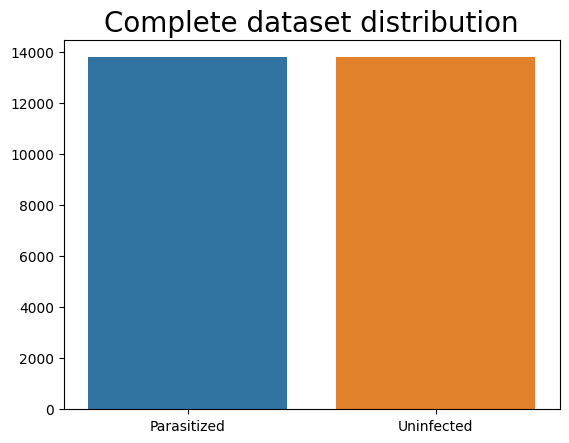

In [35]:
samplesize = pd.DataFrame.from_dict(
    {'Parasitized': [len([os.path.join(path+'/Parasitized', filename) 
                     for filename in os.listdir(path+'/Parasitized')])], 
     'Uninfected': [len([os.path.join(path+'/Uninfected', filename) 
                        for filename in os.listdir(path+'Uninfected')])]})


sns.barplot(data=samplesize).set_title('Complete dataset distribution', fontsize=20)
print(samplesize)
plt.show()

In [36]:
dataset.class_to_idx

{'Parasitized': 0, 'Uninfected': 1}

val examples:  5511 
test examples:  2756 
train exmples:  19291


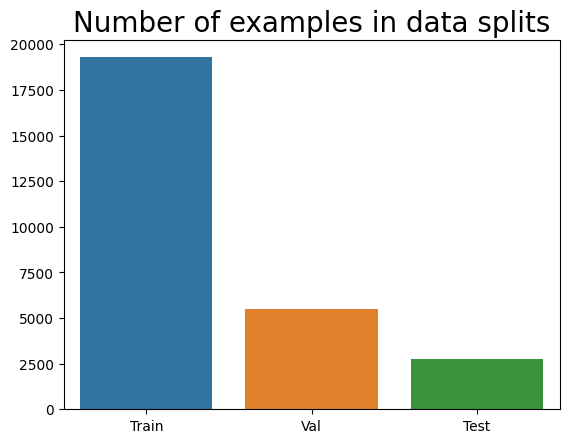

In [37]:
num_workers = 2

val_size = 0.2
test_size = 0.1



# obtain training indices that will be used for validation
num_examples = len(dataset)
indices = list(range(num_examples))
np.random.shuffle(indices)

valid_split = int(np.floor((val_size) * num_examples))
test_split = int(np.floor((val_size+test_size) * num_examples))
val_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print("val examples: ", len(val_idx), "\ntest examples: ", len(test_idx), "\ntrain exmples: ", len(train_idx))
data_splits = pd.DataFrame.from_dict({'Train': [len(train_idx)], 'Val': [len(val_idx)], 'Test': [len(test_idx)]})
sns.barplot(data=data_splits).set_title('Number of examples in data splits', fontsize=20)

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64,
    sampler=train_sampler, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=256, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=256, 
    sampler=test_sampler, num_workers=num_workers)

# Dataset examples

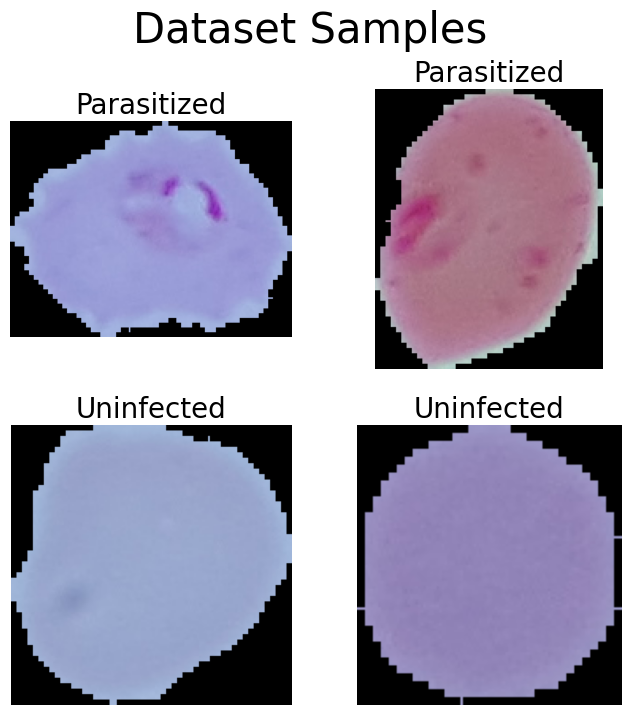

In [38]:
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//2][i%2].imshow(image)
        if i<2:
            ax[i//2][i%2].set_title("Parasitized", fontsize=20)
        else:
            ax[i//2][i%2].set_title("Uninfected", fontsize=20)
        ax[i//2][i%2].axis('off')
        
rand_samples = random.sample([os.path.join(path+'Parasitized', filename) 
                              for filename in os.listdir(path+'Parasitized')], 2) + \
    random.sample([os.path.join(path+'Uninfected', filename) 
                   for filename in os.listdir(path+'Uninfected')], 2)

plot_samples(rand_samples)
plt.suptitle('Dataset Samples', fontsize=30)
plt.savefig(save_path+'dataset_examples.png')
plt.show()

## Model ResNet50

In [39]:
class DeepClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        
        # freezing the network
        for param in self.backbone.parameters():
            param.requires_grad = False

        
        # making last conv block and classifier trainable
        self.backbone.fc = nn.Linear(2048, 2, bias=True)
        fc_parameters = self.backbone.fc.parameters()
        for param in fc_parameters:
            param.requires_grad = True
            
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True
    
    
    def forward(self, x):
        return self.backbone(x)

        
    def generate_cam(self, input_image):
        last_conv_layer = self.backbone.layer4[-1].conv3

        # Define a hook to extract the last convolutional layer's output
        conv_output = [None]
        def hook(module, input, output):
            conv_output[0] = output
            

        hook_handle = last_conv_layer.register_forward_hook(hook)
        input_image = input_image.to(next(self.parameters()).device)
        
        predicted_class = self(input_image).argmax()
        conv_output = conv_output[0]
        last_layer_weights = self.backbone.fc.weight 
        last_layer_weights_for_pred = last_layer_weights[predicted_class, :].cpu().detach().numpy()
        
        last_conv_output = conv_output.squeeze().permute((1, 2, 0)).cpu().detach().numpy() 
        h = int(input_image.shape[-1])/last_conv_output.shape[0]
        
        upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, h, 1), order=1) 
        heat_map = np.dot(upsampled_last_conv_output.reshape((224*224, 2048)), last_layer_weights_for_pred).reshape(224, 224)
        hook_handle.remove()

        return heat_map 
        
        
    

In [40]:
class EfficientnetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        
        # freezing the network
        for param in self.backbone.parameters():
            param.requires_grad = False

        
        # making last conv block and classifier trainable
        self.backbone.classifier = nn.Sequential(nn.Dropout(0.2),
                                                 nn.Linear(1280, 2, bias=True))
        fc_parameters = self.backbone.classifier.parameters()
        for param in fc_parameters:
            param.requires_grad = True
            
        for param in self.backbone.features[-4:].parameters():
            param.requires_grad = True
    
    
    def forward(self, x):
        return self.backbone(x)

        
    def generate_cam(self, input_image):
        last_conv_layer = self.backbone.features[-1][0]

        # Define a hook to extract the last convolutional layer's output
        conv_output = [None]
        def hook(module, input, output):
            conv_output[0] = output
            

        hook_handle = last_conv_layer.register_forward_hook(hook)
        input_image = input_image.to(next(self.parameters()).device)
        
        predicted_class = self(input_image).argmax()
        conv_output = conv_output[0]
        last_layer_weights = self.backbone.classifier[-1].weight 
        last_layer_weights_for_pred = last_layer_weights[predicted_class, :].cpu().detach().numpy()
        
        last_conv_output = conv_output.squeeze().permute((1, 2, 0)).cpu().detach().numpy() 
        h = int(input_image.shape[-1])/last_conv_output.shape[0]
        
        upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, h, 1), order=1) 
        heat_map = np.dot(upsampled_last_conv_output.reshape((224*224, 1280)), last_layer_weights_for_pred).reshape(224, 224)
        hook_handle.remove()

        return heat_map 
        

In [41]:
model_efficient = EfficientnetClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_efficient.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
model_efficient.to(device)
epochs = 10

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Custom convnet

In [42]:
class Classifier(nn.Module):
    def generate_conv_module(self, in_channel, out_channel, kernel_size, stride, padding, pool_kernel):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=stride),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel),
            nn.Dropout(0.2),
        )
    
    def __init__(self):
        super().__init__()
        self.conv_1 = self.generate_conv_module(3, 12, 3, 1, 1, 2)
        self.conv_2 = self.generate_conv_module(12, 24, 5, 1, 1, 2)
        self.conv_3 = self.generate_conv_module(24, 48, 3, 1, 1, 2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(48, 2),
        )
        
    def forward(self, x):
        y = self.conv_3(self.conv_2(self.conv_1(x)))
        y = self.gap(y)
        y = torch.flatten(y,1)
        y = self.fc(y)
        return y

    def generate_cam(self, input_image):
        input_image = input_image.to(next(self.parameters()).device)
        predicted_class = self(input_image).argmax()
        last_layer_weights = self.fc[-1].weight # (2, 36)
        last_layer_weights_for_pred = last_layer_weights[predicted_class, :].cpu().detach().numpy() #(36)
        
        
        last_conv_output = self.conv_3(self.conv_2(self.conv_1(input_image))).squeeze().permute((1, 2, 0)).cpu().detach().numpy() # (27, 27, 36)
        h = int(input_image.shape[-1])/last_conv_output.shape[0]
        
        upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, h, 1), order=1) # (224, 224, last_filters)
#         print(upsampled_last_conv_output.shape)
        heat_map = np.dot(upsampled_last_conv_output.reshape((224*224, 48)), last_layer_weights_for_pred).reshape(224, 224)
        return heat_map # (224, 224), CAM
        

In [43]:
model_custom = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_custom.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)
model_custom.to(device)
epochs = 10

In [44]:
summary(model_custom, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 12, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 12, 224, 224]        336
|    └─BatchNorm2d: 2-2                  [-1, 12, 224, 224]        24
|    └─ReLU: 2-3                         [-1, 12, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 12, 112, 112]        --
|    └─Dropout: 2-5                      [-1, 12, 112, 112]        --
├─Sequential: 1-2                        [-1, 24, 55, 55]          --
|    └─Conv2d: 2-6                       [-1, 24, 110, 110]        7,224
|    └─BatchNorm2d: 2-7                  [-1, 24, 110, 110]        48
|    └─ReLU: 2-8                         [-1, 24, 110, 110]        --
|    └─MaxPool2d: 2-9                    [-1, 24, 55, 55]          --
|    └─Dropout: 2-10                     [-1, 24, 55, 55]          --
├─Sequential: 1-3                        [-1, 48, 27, 27]          --
|    └─Conv

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 12, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 12, 224, 224]        336
|    └─BatchNorm2d: 2-2                  [-1, 12, 224, 224]        24
|    └─ReLU: 2-3                         [-1, 12, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 12, 112, 112]        --
|    └─Dropout: 2-5                      [-1, 12, 112, 112]        --
├─Sequential: 1-2                        [-1, 24, 55, 55]          --
|    └─Conv2d: 2-6                       [-1, 24, 110, 110]        7,224
|    └─BatchNorm2d: 2-7                  [-1, 24, 110, 110]        48
|    └─ReLU: 2-8                         [-1, 24, 110, 110]        --
|    └─MaxPool2d: 2-9                    [-1, 24, 55, 55]          --
|    └─Dropout: 2-10                     [-1, 24, 55, 55]          --
├─Sequential: 1-3                        [-1, 48, 27, 27]          --
|    └─Conv

In [45]:
summary(model_efficient, (3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNet: 1-1                           [-1, 2]                   --
|    └─Sequential: 2-1                        [-1, 1280, 7, 7]          --
|    |    └─Conv2dNormActivation: 3-1         [-1, 32, 112, 112]        (928)
|    |    └─Sequential: 3-2                   [-1, 16, 112, 112]        (1,448)
|    |    └─Sequential: 3-3                   [-1, 24, 56, 56]          (16,714)
|    |    └─Sequential: 3-4                   [-1, 40, 28, 28]          (46,640)
|    |    └─Sequential: 3-5                   [-1, 80, 14, 14]          (242,930)
|    |    └─Sequential: 3-6                   [-1, 112, 14, 14]         543,148
|    |    └─Sequential: 3-7                   [-1, 192, 7, 7]           2,026,348
|    |    └─Sequential: 3-8                   [-1, 320, 7, 7]           717,232
|    |    └─Conv2dNormActivation: 3-9         [-1, 1280, 7, 7]          412,160
|    └─AdaptiveAvgPool2d: 2-2                 

Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNet: 1-1                           [-1, 2]                   --
|    └─Sequential: 2-1                        [-1, 1280, 7, 7]          --
|    |    └─Conv2dNormActivation: 3-1         [-1, 32, 112, 112]        (928)
|    |    └─Sequential: 3-2                   [-1, 16, 112, 112]        (1,448)
|    |    └─Sequential: 3-3                   [-1, 24, 56, 56]          (16,714)
|    |    └─Sequential: 3-4                   [-1, 40, 28, 28]          (46,640)
|    |    └─Sequential: 3-5                   [-1, 80, 14, 14]          (242,930)
|    |    └─Sequential: 3-6                   [-1, 112, 14, 14]         543,148
|    |    └─Sequential: 3-7                   [-1, 192, 7, 7]           2,026,348
|    |    └─Sequential: 3-8                   [-1, 320, 7, 7]           717,232
|    |    └─Conv2dNormActivation: 3-9         [-1, 1280, 7, 7]          412,160
|    └─AdaptiveAvgPool2d: 2-2                 

## Training The Network

In [46]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# save the losses for further visualization

loaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_idx), 'val': len(val_idx)}


def train(model, criterion, optimizer, scheduler, epochs, losses, accuracies):
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for (inputs, labels) in tqdm(loaders[phase]):
                (inputs, labels) = (inputs.to(device),
                                    labels.to(device))

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outp = model(inputs)
#                     print(outp)
                    (_, pred) = torch.max(outp, 1)
                    loss = criterion(outp, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == 'train':
                print('Epoch: {}/{}'.format(epoch + 1, epochs))
            print('{} - loss:{}, accuracy: {}'.format(phase, epoch_loss,
                    epoch_acc))

            if phase == 'val':
                print('Time: {}m {}s'.format((time.time() - since)
                        // 60, (time.time() - since) % 60))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
        scheduler.step()
    time_elapsed = time.time() - since
    print('Training Time {}m {}s'.format(time_elapsed // 60,
            time_elapsed % 60))
    print('Best accuracy {}'.format(best_acc))

    model.load_state_dict(best_model)
    return model


# training custom convnet

In [47]:

optimizer_custom = torch.optim.Adam(model_custom.parameters(), lr = 0.001)
scheduler_custom = torch.optim.lr_scheduler.StepLR(optimizer_custom, 4, gamma=0.1)
losses_custom = {'train': [], 'val': []}
accuracies_custom = {'train': [], 'val': []}
model_custom = train(model_custom, criterion, optimizer_custom, scheduler_custom, epochs, losses_custom, accuracies_custom)

100%|██████████| 302/302 [01:05<00:00,  4.62it/s]


Epoch: 1/10
train - loss:0.6027045297984801, accuracy: 0.6912031517287854


100%|██████████| 22/22 [00:16<00:00,  1.33it/s]


val - loss:0.5302692680626248, accuracy: 0.8372346216657593
Time: 1.0m 21.981827974319458s


100%|██████████| 302/302 [00:59<00:00,  5.10it/s]


Epoch: 2/10
train - loss:0.499659965106089, accuracy: 0.8017728474418122


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


val - loss:0.42912351304769647, accuracy: 0.8960261295590637
Time: 2.0m 36.1758131980896s


100%|██████████| 302/302 [00:57<00:00,  5.25it/s]


Epoch: 3/10
train - loss:0.40285272392735477, accuracy: 0.8627339173707946


100%|██████████| 22/22 [00:15<00:00,  1.40it/s]


val - loss:0.34607822345943207, accuracy: 0.9207040464525494
Time: 3.0m 49.37094783782959s


100%|██████████| 302/302 [00:56<00:00,  5.34it/s]


Epoch: 4/10
train - loss:0.31152029490064276, accuracy: 0.8952361204706858


100%|██████████| 22/22 [00:15<00:00,  1.42it/s]


val - loss:0.3226550214034506, accuracy: 0.8873162765378334
Time: 5.0m 1.449737310409546s


100%|██████████| 302/302 [00:57<00:00,  5.27it/s]


Epoch: 5/10
train - loss:0.2523978587600518, accuracy: 0.9200663521849567


100%|██████████| 22/22 [00:15<00:00,  1.46it/s]


val - loss:0.3327651103845938, accuracy: 0.8762475049900199
Time: 6.0m 13.893056631088257s


100%|██████████| 302/302 [00:58<00:00,  5.18it/s]


Epoch: 6/10
train - loss:0.23688687665528863, accuracy: 0.9264942201026386


100%|██████████| 22/22 [00:15<00:00,  1.39it/s]


val - loss:0.3316015926490698, accuracy: 0.8789693340591545
Time: 7.0m 28.021819829940796s


100%|██████████| 302/302 [00:56<00:00,  5.30it/s]


Epoch: 7/10
train - loss:0.23095508569102347, accuracy: 0.9263905448136437


100%|██████████| 22/22 [00:15<00:00,  1.39it/s]


val - loss:0.33200729417294733, accuracy: 0.8829613500272183
Time: 8.0m 40.86486291885376s


100%|██████████| 302/302 [00:57<00:00,  5.21it/s]


Epoch: 8/10
train - loss:0.23105147979459523, accuracy: 0.9272199471256026


100%|██████████| 22/22 [00:15<00:00,  1.40it/s]


val - loss:0.3115112296878653, accuracy: 0.8873162765378334
Time: 9.0m 54.605411529541016s


100%|██████████| 302/302 [00:57<00:00,  5.24it/s]


Epoch: 9/10
train - loss:0.22333824037609523, accuracy: 0.9293452905499974


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


val - loss:0.316578769236073, accuracy: 0.8862275449101796
Time: 11.0m 6.973579168319702s


100%|██████████| 302/302 [00:59<00:00,  5.12it/s]


Epoch: 10/10
train - loss:0.22179460130795295, accuracy: 0.9310040951739154


100%|██████████| 22/22 [00:15<00:00,  1.40it/s]

val - loss:0.3183341759061493, accuracy: 0.8858646343676284
Time: 12.0m 21.773744821548462s
Training Time 12.0m 21.77412748336792s
Best accuracy 0.9207040464525494


## training efficientnet based model

In [48]:
optimizer_efficient = torch.optim.Adam(model_efficient.parameters(), lr = 0.001)
scheduler_efficient = torch.optim.lr_scheduler.StepLR(optimizer_efficient, 4, gamma=0.1)
losses_efficient = {'train': [], 'val': []}
accuracies_efficient = {'train': [], 'val': []}
model_efficient = train(model_efficient, criterion, optimizer_efficient, scheduler_efficient, epochs, losses_efficient, accuracies_efficient)

100%|██████████| 302/302 [01:04<00:00,  4.69it/s]


Epoch: 1/10
train - loss:0.13517410420783169, accuracy: 0.9555233010212016


100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


val - loss:0.09310957204027977, accuracy: 0.966612230085284
Time: 1.0m 21.821038246154785s


100%|██████████| 302/302 [01:04<00:00,  4.67it/s]


Epoch: 2/10
train - loss:0.10086299899601898, accuracy: 0.9656834793426987


100%|██████████| 22/22 [00:18<00:00,  1.22it/s]


val - loss:0.08610941796164573, accuracy: 0.9673380511703865
Time: 2.0m 44.50790476799011s


100%|██████████| 302/302 [01:04<00:00,  4.67it/s]


Epoch: 3/10
train - loss:0.08944210475312131, accuracy: 0.9676533098336012


100%|██████████| 22/22 [00:18<00:00,  1.20it/s]


val - loss:0.0845713443226735, accuracy: 0.9718744329522773
Time: 4.0m 7.540250301361084s


100%|██████████| 302/302 [01:05<00:00,  4.62it/s]


Epoch: 4/10
train - loss:0.08258928130974381, accuracy: 0.9718003213933959


100%|██████████| 22/22 [00:18<00:00,  1.19it/s]


val - loss:0.08259486918821134, accuracy: 0.9698784249682453
Time: 5.0m 31.376953601837158s


100%|██████████| 302/302 [01:04<00:00,  4.68it/s]


Epoch: 5/10
train - loss:0.06328340208262756, accuracy: 0.9782800269555751


100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


val - loss:0.0696976523102141, accuracy: 0.9736889856650336
Time: 6.0m 53.35065221786499s


100%|██████████| 302/302 [01:07<00:00,  4.45it/s]


Epoch: 6/10
train - loss:0.053981314074099576, accuracy: 0.98040537037997


100%|██████████| 22/22 [00:17<00:00,  1.29it/s]


val - loss:0.06766578496196021, accuracy: 0.9745962620214117
Time: 8.0m 18.336506605148315s


100%|██████████| 302/302 [01:04<00:00,  4.69it/s]


Epoch: 7/10
train - loss:0.05270292036933233, accuracy: 0.9804572080244673


100%|██████████| 22/22 [00:17<00:00,  1.29it/s]


val - loss:0.06407930011328866, accuracy: 0.9751406278352386
Time: 9.0m 39.88215088844299s


100%|██████████| 302/302 [01:04<00:00,  4.66it/s]


Epoch: 8/10
train - loss:0.048651519146771106, accuracy: 0.9823752008708725


100%|██████████| 22/22 [00:18<00:00,  1.20it/s]


val - loss:0.07026170659624412, accuracy: 0.9727817093086554
Time: 11.0m 3.081179141998291s


100%|██████████| 302/302 [01:06<00:00,  4.55it/s]


Epoch: 9/10
train - loss:0.045569397049592154, accuracy: 0.983878492561298


100%|██████████| 22/22 [00:17<00:00,  1.29it/s]


val - loss:0.0656657569560592, accuracy: 0.9774995463618218
Time: 12.0m 26.616570472717285s


100%|██████████| 302/302 [01:06<00:00,  4.52it/s]


Epoch: 10/10
train - loss:0.04469278176397635, accuracy: 0.983515629049816


100%|██████████| 22/22 [00:18<00:00,  1.18it/s]

val - loss:0.06860961377042063, accuracy: 0.9760479041916168
Time: 13.0m 52.077954053878784s
Training Time 13.0m 52.078333377838135s
Best accuracy 0.9774995463618218


# Graphs 

In [53]:
def plot_graphs(losses, accuracies, title=''):
    accuracies['train'] = torch.Tensor(accuracies['train']).cpu().numpy()
    accuracies['val'] = torch.Tensor(accuracies['val']).cpu().numpy()
    losses['train'] = torch.Tensor(losses['train']).cpu().numpy()
    losses['val'] = torch.Tensor(losses['val']).cpu().numpy()

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, accuracies['train'], label='Train Accuracy')
    ax1.plot(epoch_list, accuracies['val'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, epochs+1))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, losses['train'], label='Train Loss')
    ax2.plot(epoch_list, losses['val'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, epochs+1))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
    plt.savefig(save_path+'title'+'.png')

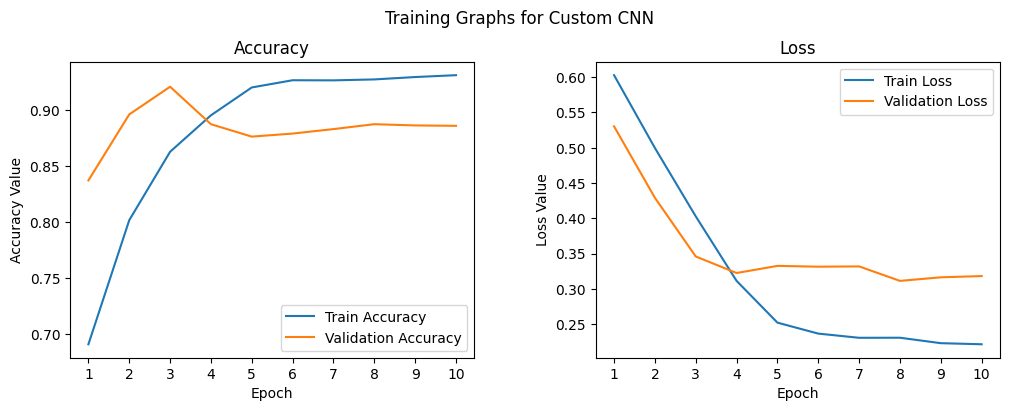

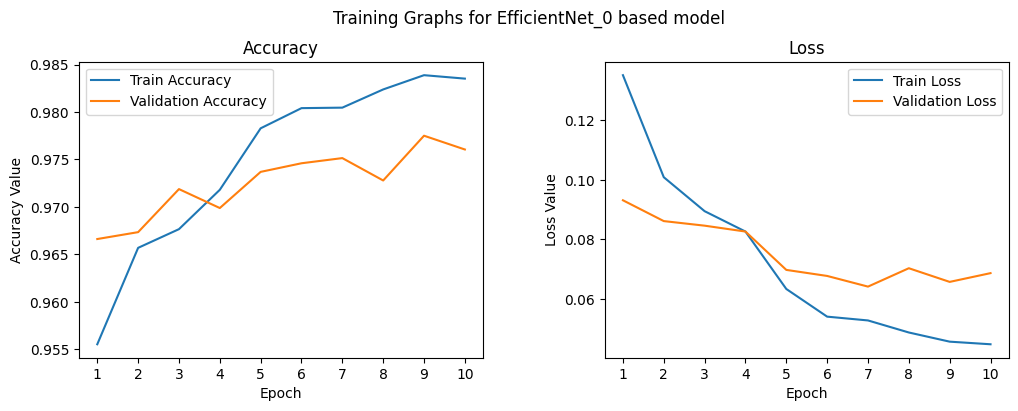

In [54]:
plot_graphs(losses_custom, accuracies_custom, 'Training Graphs for Custom CNN')
plot_graphs(losses_efficient, accuracies_efficient, 'Training Graphs for EfficientNet_0 based model')

## Testing The Model

In [60]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def validation_step(batch, model):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    
def test_prediction(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()           
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()             
    # combine predictions
    batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
    # combine labels
    batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  

    return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
            'test_preds': batch_preds, 'test_labels': batch_labels}  

@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch, model) for batch in tqdm(test_loader)] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

# Plot confusion matrix
def plot_cm(labels, preds, title=''):
    cm  = confusion_matrix(labels, preds, labels=[1,0])
    # NOTE: here we have assumed that 0(parasitized): positive, 1(Uninfected): negative
    
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Uninfected', 'Parasitized'], fontsize=16)
    plt.yticks(range(2), ['Uninfected', 'Parasitized'], fontsize=16)
    plt.xlabel('Predicted Label',fontsize=18)
    plt.ylabel('True Label',fontsize=18)
    plt.title(title, fontsize=24)
    plt.show()
    return cm

def calculate_metrics(cm, preds, labels):
    # Compute Performance Metrics
    tn, fp, fn, tp = cm.ravel()

    accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))

    print("Accuracy of the model is {:.2f}".format(accuracy))
    print("Recall of the model is {:.2f}".format(recall))
    print("Precision of the model is {:.2f}".format(precision))
    print("F1 Score of the model is {:.2f}".format(f1))

In [56]:
preds_custom,labels_custom = test_predict(model_custom, test_loader)
preds_efficient, labels_efficient = test_predict(model_efficient, test_loader)

100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


test_loss: 0.3527, test_acc: 0.9170


100%|██████████| 11/11 [00:08<00:00,  1.25it/s]

test_loss: 0.0660, test_acc: 0.9744


<Figure size 640x480 with 0 Axes>

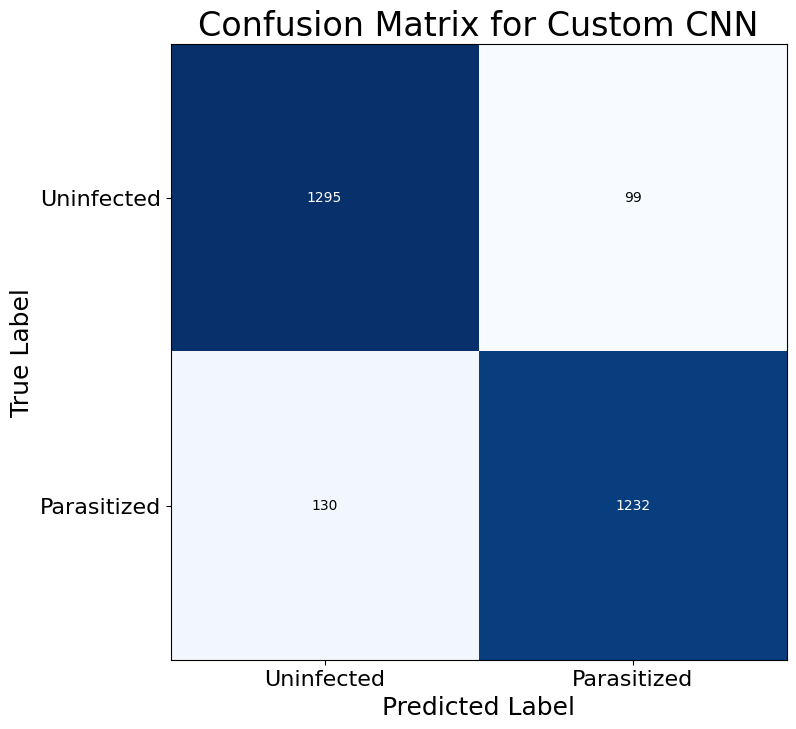

<Figure size 640x480 with 0 Axes>

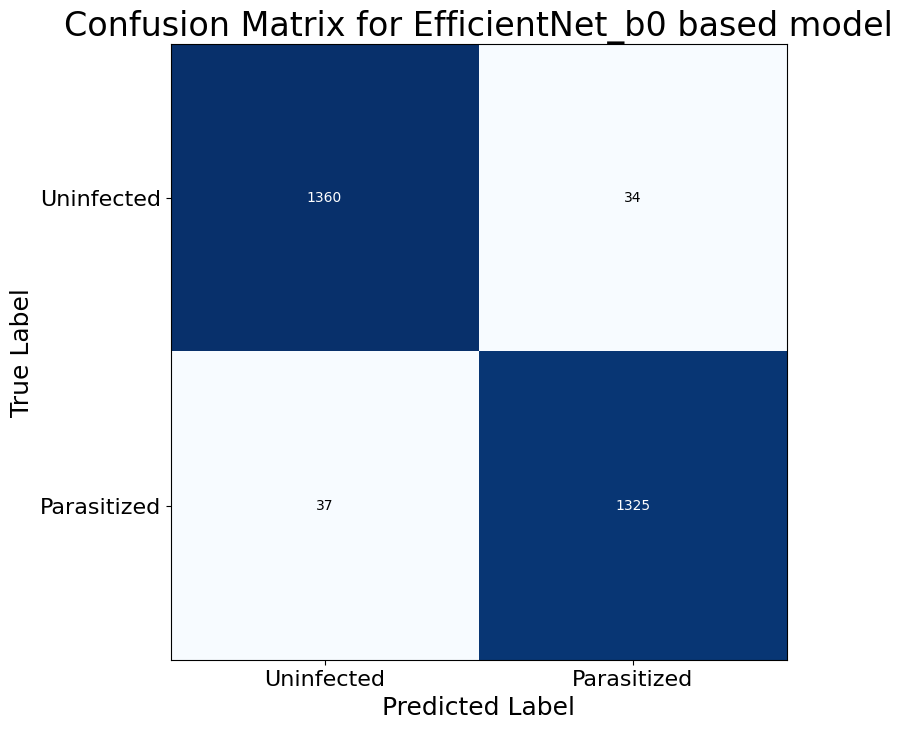

In [61]:
cm_custom = plot_cm(labels_custom, preds_custom, title='Confusion Matrix for Custom CNN')
cm_efficient = plot_cm(labels_efficient, preds_efficient, title='Confusion Matrix for EfficientNet_b0 based model')

In [62]:
print("For custom CNN:")
calculate_metrics(cm_custom, preds_custom, labels_custom)
print("\n\nFor EfficientNet_b0 based model:")
calculate_metrics(cm_efficient, preds_efficient, labels_efficient)

For custom CNN:
Accuracy of the model is 0.92
Recall of the model is 0.90
Precision of the model is 0.93
F1 Score of the model is 0.91


For EfficientNet_b0 based model:
Accuracy of the model is 0.97
Recall of the model is 0.97
Precision of the model is 0.97
F1 Score of the model is 0.97


# CAM visualization

In [63]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

def predict_malaria(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

Parasitized


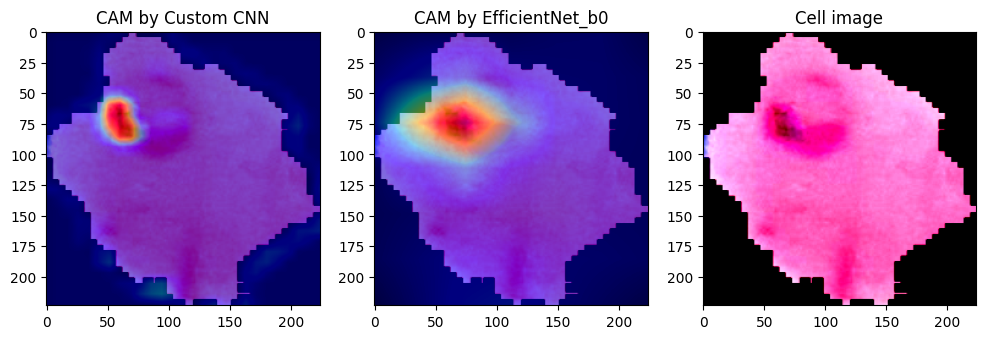

Parasitized


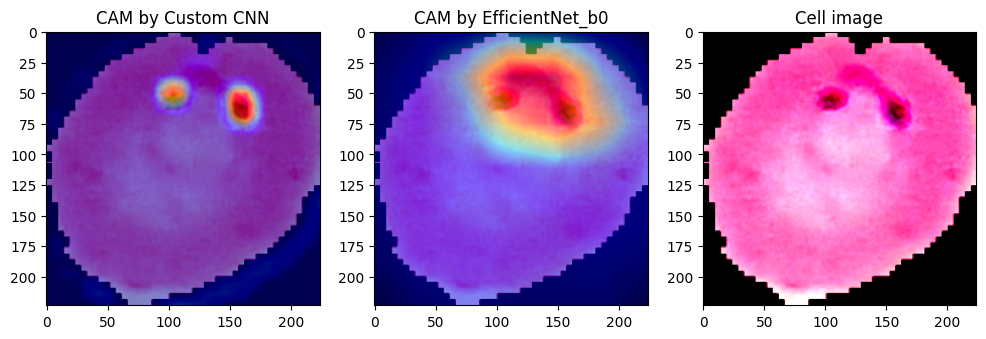

Parasitized


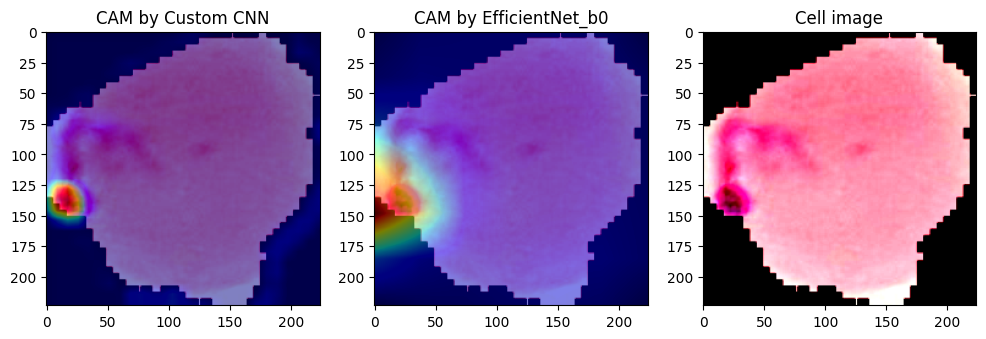

Uninfected


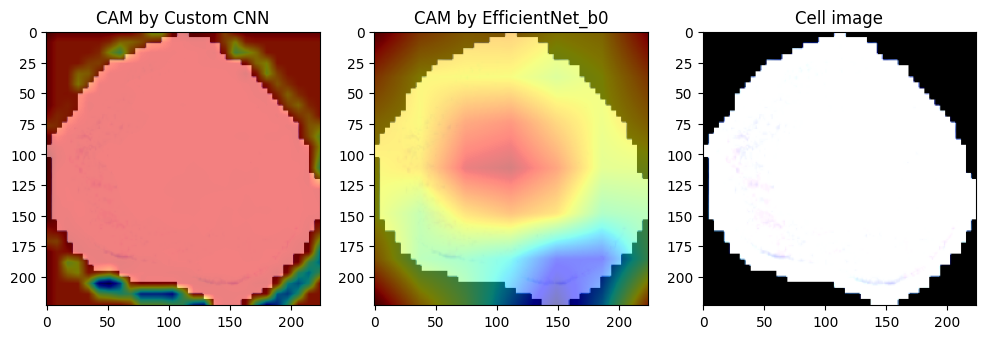

Uninfected


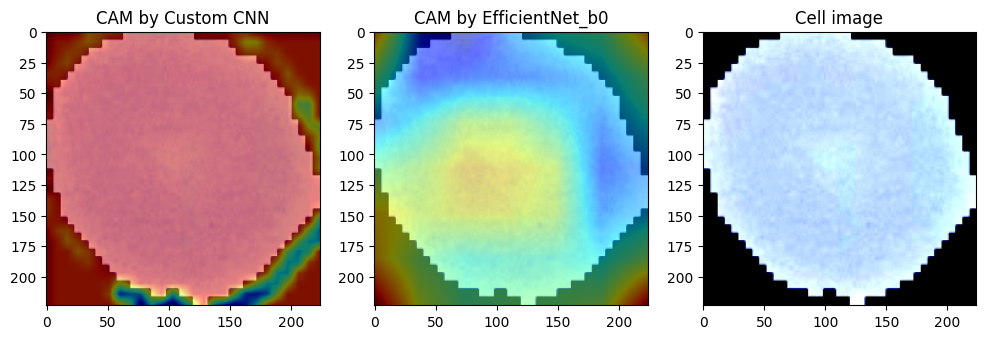

Uninfected


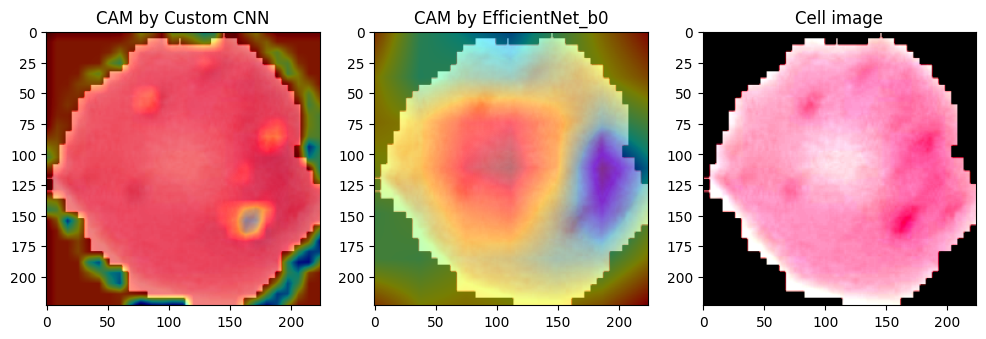

In [64]:
from glob import glob
from PIL import Image
from termcolor import colored

class_names=['Parasitized','Uninfected']
inf = np.array(glob(path+"Parasitized/*"))
uninf = np.array(glob(path+"Uninfected/*"))
for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    
    processed_img = load_input_image(img_path)
    cam_custom = model_custom.generate_cam(processed_img)
    cam_efficient = model_efficient.generate_cam(processed_img)

#     cam[processed_img[0, 0, :, :] == 0] = 0
    
    if predict_malaria(model_custom, class_names, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    ax1.imshow(processed_img.squeeze().permute(1, 2, 0))
    ax1.imshow(cam_custom, cmap='jet', alpha=0.5)
    ax1.set_title('CAM by Custom CNN')
    ax2.imshow(processed_img.squeeze().permute(1,2,0))
    ax2.imshow(cam_efficient, cmap='jet', alpha=0.5)
    ax2.set_title('CAM by EfficientNet_b0')
    ax3.imshow(processed_img.squeeze().permute(1,2,0))
    ax3.set_title('Cell image')
    plt.show()
for i in range(3):
    img_path=uninf[i]
    img = Image.open(img_path)
    processed_img = load_input_image(img_path)
    cam_custom = model_custom.generate_cam(processed_img)
    cam_efficient = model_efficient.generate_cam(processed_img)
#     cam[processed_img[0, 0, :, :] < 10] = 0

    
    if predict_malaria(model_custom, class_names, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))  
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    ax1.imshow(processed_img.squeeze().permute(1, 2, 0))
    ax1.imshow(cam_custom, cmap='jet', alpha=0.5)
    ax1.set_title('CAM by Custom CNN')

    ax2.imshow(processed_img.squeeze().permute(1,2,0))
    ax2.imshow(cam_efficient, cmap='jet', alpha=0.5)
    ax2.set_title('CAM by EfficientNet_b0')

    ax3.imshow(processed_img.squeeze().permute(1,2,0))
    ax3.set_title('Cell image')

    plt.show()